# Lab 5 Exploration: AR Markers

In this notebook, we will learn how to use ArUco library to detect AR Markers in a color image.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.


## Table of Contents
1. [Getting Started](#GettingStarted)
1. [Detecting AR Markers](#DetectingARMarkers)
1. [Organizing AR Marker Data](#OrganizingData)
1. [Detecting Orientation](#DetectingOrientation)
1. [Detecting Color](#DetectingColor)

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [1]:
# TODO: Update isSimulation if necessary
isSimulation = True

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [2]:
# Import Python libraries
import math
import copy
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statistics
from nptyping import NDArray
from typing import Any, Tuple, List, Optional
from enum import Enum

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core
import racecar_utils as rc_utils

The following function allows us to display images in the Jupyter Notebook.

In [3]:
def show_image(image, size = 8) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.figure(figsize=(size, size), dpi=100)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [4]:
# Create Racecar
rc = racecar_core.create_racecar(isSimulation)

>> Racecar created with the following options:
    Simulation (-s): [True]
    Headless (-h): [False]
    Initialize with display (-d): [False]


<a id="DetectingARMarkers"></a>
## 2. Detecting AR Markers
Similar to QR codes, AR Markers are special patterns designed to be easily recognized by computers. In this course, we will work with ArUco markers, which can be detected with the ArUco library in OpenCV. Each pattern has a unique ID number, and the ArUco library can detect which direction a marker is facing.

To begin, lets take a color image.

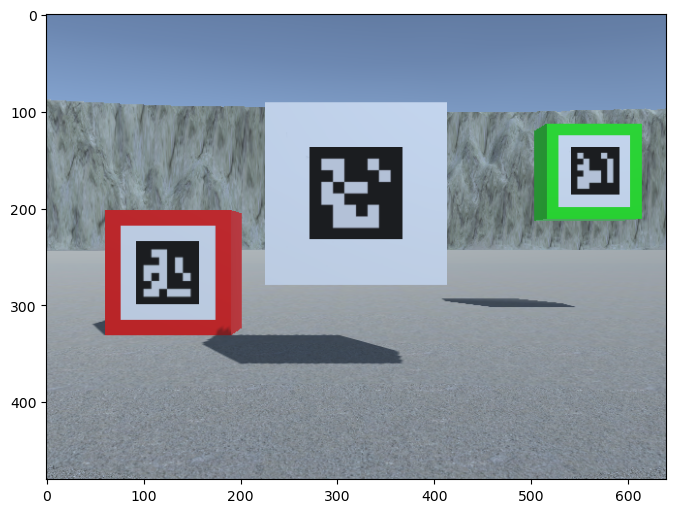

In [5]:
# Access the current color image
image = rc.camera.get_color_image_async()
show_image(image)

Next, we will detect the markers in this image with the `cv.aruco.detectMarkers` function. This returns an object containing lots of information about the markers. We will explore what all of this information means in the next section.

In [6]:
# Detect and AR Markers
ar_markers = cv.aruco.detectMarkers(
    image,
    cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250),
    parameters=cv.aruco.DetectorParameters_create()
)
ar_markers

((array([[[157., 235.],
          [157., 299.],
          [ 93., 299.],
          [ 93., 235.]]], dtype=float32),
  array([[[591., 186.],
          [542., 186.],
          [542., 138.],
          [591., 138.]]], dtype=float32),
  array([[[272., 138.],
          [367., 138.],
          [367., 232.],
          [272., 232.]]], dtype=float32)),
 array([[2],
        [1],
        [3]], dtype=int32),
 (array([[[124., 284.],
          [149., 283.],
          [150., 291.],
          [125., 293.]]], dtype=float32),
  array([[[140., 268.],
          [149., 267.],
          [150., 275.],
          [141., 276.]]], dtype=float32),
  array([[[ 75., 214.],
          [178., 216.],
          [177., 319.],
          [ 72., 317.]]], dtype=float32),
  array([[[307., 174.],
          [331., 173.],
          [332., 185.],
          [308., 186.]]], dtype=float32),
  array([[[343., 162.],
          [355., 161.],
          [356., 173.],
          [343., 174.]]], dtype=float32),
  array([[[579., 149.],
         

Finally, we can use the `cv.aruco.drawDetectedMarkers` function to annotate the AR markers in our color image. The function takes the following parameters:
1. The color image in which the markers were detected.
2. The corners of the markers (which is the 0th entry in the object returned by `detectMarkers`).
3. The IDs of the markers (which is the 1st entry in the object returned by `detectMarkers`).
4. The color with which to annotate the image.

It does the following for each AR marker detected in the image:
* Outlines the marker in the specified color
* Draws a box at the top left corner of the _pattern_. This means that if the pattern is not facing upward, this box will not be in the top left corner relative to the image.
* Annotates the marker with `id=N`, where $N$ is the index of the pattern.

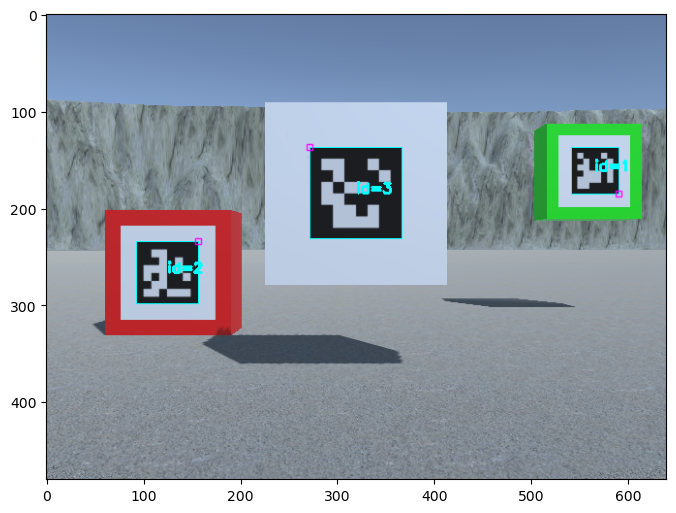

In [7]:
color = (255, 255, 0)
cv.aruco.drawDetectedMarkers(image, ar_markers[0], ar_markers[1], color)

show_image(image)

Notice that `drawDetectedMarkers` draws the annotations **directly on top of the image we pass it**. This can be a problem if we need to do additional computation on the image, such as detecting contours. In this case, we should first create a *deep copy* of the image with [`copy.deepcopy()`](https://docs.python.org/3/library/copy.html).

**<span style="color:red">Modify the following code block to make a deep copy of `image` before drawing the detected markers.</span>** When you run this code, it should print two images: the first should be unannotated and the second should be annotated.

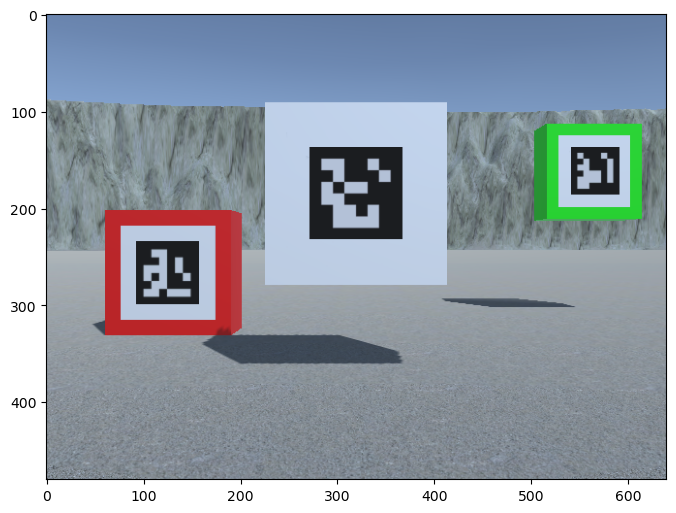

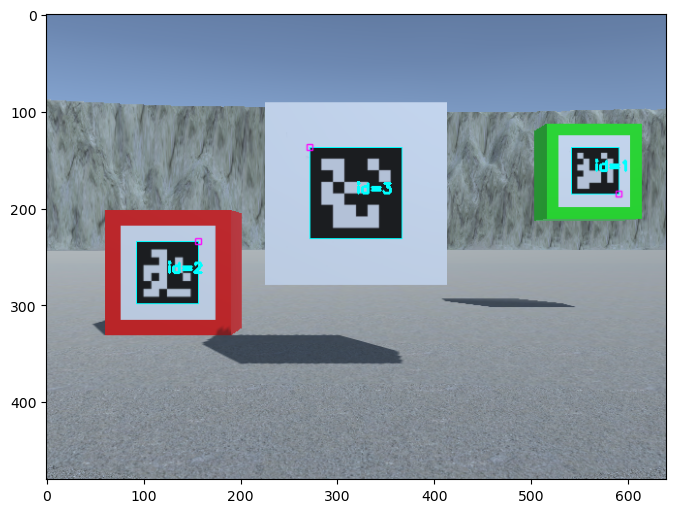

In [11]:
image = rc.camera.get_color_image_async()
ar_markers = cv.aruco.detectMarkers(
    image,
    cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250),
    parameters=cv.aruco.DetectorParameters_create()
)

# TODO: Make a deep copy of image
image_copy = copy.deepcopy(image)

color = (255, 255, 0)
cv.aruco.drawDetectedMarkers(image_copy, ar_markers[0], ar_markers[1], color)

show_image(image)
show_image(image_copy)

<a id="OrganizingData"></a>
## 3. Organizing AR Marker Data

### 3.1 Unpacking the data

In order to use AR markers in our programs, we will need to understand the information returned by the `detectMarkers` function.

If we print out the `ar_markers` object returned by `detectMarkers`, we see that it is a mess of deeply nested array. To use this data, we will need to start separating out useful pieces.

In [12]:
ar_markers

((array([[[157., 235.],
          [157., 299.],
          [ 93., 299.],
          [ 93., 235.]]], dtype=float32),
  array([[[591., 186.],
          [542., 186.],
          [542., 138.],
          [591., 138.]]], dtype=float32),
  array([[[272., 138.],
          [367., 138.],
          [367., 232.],
          [272., 232.]]], dtype=float32)),
 array([[2],
        [1],
        [3]], dtype=int32),
 (array([[[124., 284.],
          [149., 283.],
          [150., 291.],
          [125., 293.]]], dtype=float32),
  array([[[140., 268.],
          [149., 267.],
          [150., 275.],
          [141., 276.]]], dtype=float32),
  array([[[ 75., 214.],
          [178., 216.],
          [177., 319.],
          [ 72., 317.]]], dtype=float32),
  array([[[307., 174.],
          [331., 173.],
          [332., 185.],
          [308., 186.]]], dtype=float32),
  array([[[343., 162.],
          [355., 161.],
          [356., 173.],
          [343., 174.]]], dtype=float32),
  array([[[579., 149.],
         

The 0th entry in `ar_markers` is an array containing the corners of each AR marker in the image, and the 1st entry is an array containing the ids of each AR marker in the image.

In [13]:
corners = ar_markers[0]
ids = ar_markers[1]

In [14]:
corners

(array([[[157., 235.],
         [157., 299.],
         [ 93., 299.],
         [ 93., 235.]]], dtype=float32),
 array([[[591., 186.],
         [542., 186.],
         [542., 138.],
         [591., 138.]]], dtype=float32),
 array([[[272., 138.],
         [367., 138.],
         [367., 232.],
         [272., 232.]]], dtype=float32))

In [15]:
ids

array([[2],
       [1],
       [3]], dtype=int32)

Unfortunately, the corners are not represented in a format compatible with the racecar library. First, each corner is shown in (pixel column, pixel row) order instead of (pixel row, pixel column) order. Second, each row and column is stored as a `float32` (which allows for fractional numbers). This does not make much sense, since we can only have whole numbered rows or columns. We will want to convert each row and column to an `int32`, which only allows for whole numbers.

Notice that the data is stored in deeply nested arrays, so we will need to "unpack" these arrays to access the data we want. For example, each entry in the `ids` array is itself a 1-entry array containing the id. Thus the id of the first AR marker is `ids[0][0]`, the id of the next AR marker is `ids[1][0]`, and so on.

**<span style="color:red">Finish writing the following code block to extract the corners and id of the first detected AR marker (index 0).</span>** The corners should be in (row, column) order, formatted as integers.

In [128]:
# Access the corners of the first AR marker detected, converting the data type from float32 to int32
first_corners = corners[0][0].astype(np.int32)

# TODO: Swap each corner from (col, row) to (row, col) format
new = []
for i in first_corners:
    temp = (i[1], i[0])
    new.append(temp)
first_corners = new

# TODO: Set first_id to the id of the first AR marker detected
print(ids[0][0])
first_id = ids[0][0]

print("first_corners: ", first_corners)
print("first_id: ", first_id)

2
first_corners:  [(235, 157), (299, 157), (299, 93), (235, 93)]
first_id:  2


### 3.2 Creating the ARMarker Class
Rather than storing the corners and ID separately, it would be nice to have a single object which stores all of the information we know about a single marker. This will become especially useful once we calculate the orientation and color of the marker later on.

To do this, we will create a *class*, which specifies a new type of object. For example, once we define the `ARMarker` class, we can create new objects of type `ARMarker`.

A class consists of two things:
1. **Fields**: Fields are the variables which store the data associated with a class. For now, we will create an `id` field to store the ID and a `corners` field to store the corner points.
2. **Methods**: Methods are types of functions which can be called on an object of our class. The first parameter of every method is called `self` and refers to the object on which the method was called.

The `__init__` method is a special method called a _constructor_ which is used to create new objects of our class. Traditionally, this is also where we define the fields of our class. We will write the `ARMarker` constructor to take the id and corners of the marker.

**<span style="color:red">Finishing writing the `ARMarker` constructor to assign the `id` and `corners` fields the correct value.</span>**

In [18]:
class ARMarker:
    
    def __init__(self, marker_id, marker_corners):
        # TODO: Assign the id field to the marker_id parameter
        self.id = marker_id
            
        # TODO: Assign the corners field to the marker_corners parameter
        self.corners = marker_corners

We can now call this constructor to create an `ARMarker` object storing the id and corners were calculated previously. Notice that we do not need to pass in an argument for the `self` parameter: this is handled automatically by Python.

In [19]:
# Create an ARMarker object storing the id and corners of the first detected AR marker
first_marker = ARMarker(first_id, first_corners)

# Print the id and corners fields of first_marker
print("first_marker.id: ", first_marker.id)
print("first_marker.corners: ", first_marker.corners)

first_marker.id:  2
first_marker.corners:  [[157 235]
 [157 299]
 [ 93 299]
 [ 93 235]]


The previously example demonstrated how to read the fields of an object. We can also write to the fields of an object.

In [20]:
first_marker.id = 20
print("first_marker.id: ", first_marker.id)

first_marker.id:  20


### 3.3 Private Fields
We do not want users of our `ARMarker` class to change the id or corners after they were initially detected. We will therefore make these fields *private* by appending a double underscore (`__`) to the front of their name. This indicates that these fields should only be accessed by methods of our `ARMarker` class and not outside of our class.

We will then add `get_id()` and `get_corners()` methods which allow users to access the values of the `__id` and `__corners` fields without changing them. Methods like these which simply return the value of a field are called _accessors_ or _getters_. 

In [24]:
class ARMarker:
    
    def __init__(self, marker_id, marker_corners):
        # TODO: Assign the __id and __corners fields
        __id = marker_id
        __corners = marker_corners
            
    def get_id(self):
        # TODO: Return the marker ID
        return id
    
    def get_corners(self):
        # TODO: Return the marker corner points
        return  corners

We can create an ARMarker object the same as before, but we now use `get_id()` and `get_corners()` methods to access the id and corners. Once again, remember that we do not explicitly pass in the `self` argument. 

In [25]:
first_marker = ARMarker(first_id, first_corners)

print("first_marker.get_id(): ", first_marker.get_id())
print("first_marker.get_corners(): ", first_marker.get_corners())

first_marker.get_id():  <built-in function id>
first_marker.get_corners():  (array([[[157., 235.],
        [157., 299.],
        [ 93., 299.],
        [ 93., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32))


Because `__id` is private, we can no longer access it with `first_marker.__id`. This helps deter users from accidentally overwriting the marker's ID.

In [26]:
first_marker.__id = 20
print("first_marker.get_id(): ", first_marker.get_id())

first_marker.get_id():  <built-in function id>


### 3.4 Adding `__str__`
At the moment, if we try to print an `ARMarker` object, it simply tells us where the object is stored in memory, which is not particularly helpful.

In [27]:
print(first_marker)

To fix this, we will need to implement `__str__` for the `ARMarker` class. `__str__` is another special method which is used to convert an object to a string. It is automatically called when we print the object with `print()` or convert it to a string with `str()`.

**<span style="color:red">Finish writing the `__str__` method to print the ID and corners of the marker.</span>**

In [37]:
class ARMarker:
    
    def __init__(self, marker_id, marker_corners):
        # TODO: copy implementation from your previous ARMarker class
        __id = marker_id
        __corners = marker_corners
            
    def get_id(self):
        # TODO: Copy implementation from your previous ARMarker class
        return id
    
    def get_corners(self):
        # TODO: Copy implementation from your previous ARMarker class
        return corners
    
    def __str__(self):
        # TODO: Return a string listing the ID and corners of the marker
        ret = str(id) + ", " + str(corners)
        return ret

We will now get a more helpful message if we print an `ARMarker` object with the `print()` function.

In [38]:
first_marker = ARMarker(first_id, first_corners)
print(first_marker)

<built-in function id>, (array([[[157., 235.],
        [157., 299.],
        [ 93., 299.],
        [ 93., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32))


### 3.5 Bringing It Together
Is section **3.1**, we learned how to extract corner and id information about the AR markers in an image. In sections **3.2 - 3.4**, we created the `ARMarker` class to organize the corner and id information for a single AR marker. In this section, we will put these pieces together to create a single function which extracts all of the AR markers in an image and returns them as a list of `ARMarker` objects.

**<span style="color:red">Finish writing the `get_ar_markers()` function to return a list of `ARMarker` objects detected in an image.</span>** Remember that the ArUco library represents the corners as `float32`s in (col, row) format, but we want them as `int32`s in (row, col) format. You may wish to revisit your code from section **3.1**.

In [199]:
def get_ar_markers(image):
    # Gather raw AR marker data from ArUco
    aruco_data = cv.aruco.detectMarkers(
        image,
        cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250),
        parameters=cv.aruco.DetectorParameters_create()
    )
    
    # A list of ARMarker objects representing the AR markers found in aruco_data
    markers = []
    print((aruco_data[0]))
    for i in range(len((aruco_data[0]))):
        # TODO: For each marker in aruco_data, extract the corners and id, change the corners into (row, col) format,
        # and create an ARMarker object with this data (see section 3.1)
        arr = aruco_data[0][i]
        for j in range(len(arr)):
            temp = arr[j][0]
            arr[j][0]= arr[j][1]
            arr[j][1] = temp
        markers.append(ARMarker(ids[i][0], arr))
        # TODO: Add the new marker to markers

        
    return markers

We can now use `get_ar_markers()` to identify all of the AR markers in an image.

In [200]:
image = rc.camera.get_color_image_async()
markers = get_ar_markers(image)

for marker in markers:
    print(marker)
    print("\n----\n")

(array([[[157., 235.],
        [157., 299.],
        [ 92., 299.],
        [ 92., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32))
START
[[[157. 299.]
  [157. 299.]
  [ 92. 299.]
  [ 92. 235.]]]
STOP
START
[[[542. 186.]
  [542. 186.]
  [542. 138.]
  [591. 138.]]]
STOP
START
[[[367. 138.]
  [367. 138.]
  [367. 232.]
  [272. 232.]]]
STOP
<built-in function id>, (array([[[157., 235.],
        [157., 299.],
        [ 93., 299.],
        [ 93., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32)), Orientation.UP

----

<built-in function id>, (array([[[157., 235.],
        [157., 299.],
        [ 93., 299.],
        [ 93., 23

# <a id="DetectingOrientation"></a>
## 4. Detecting Orientation
AR marker patterns are not symmetric, allowing ArUco to always identify the "top" of the pattern regardless of how it is rotated. The corner data returned by ArUco always begins with the top left corner of the pattern and continues clockwise.

We can use this information to determine the orientation of an AR marker in an image, which we can then use to make decisions.  For example, we may wish to turn right when the marker is oriented to the right and left when the marker is oriented to the left.

We will create an `Enum` to represent the four possible orientations (up, left, down, right). An enum is a special type of class in which each member has a unique constant value. These members are usually used to represent different options for the category represented by the enum class.

The following code block defines an `Orientation` enum with members representing the four orientations (up, left, down, right). Each member has a unique constant value ranging from 0 to 3 inclusive.

In [137]:
class Orientation(Enum):
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3

Enum values have some nice properties:
* Enum values can be stored in variables. For example, we may wish to define a variable storing the orientation of a marker.
* We can directly compare enum values with `==`, which returns `true` if the enum values are the same and `false` otherwise. For example, `Orientation.UP == Orientation.UP` returns `true`, while `Orientation.UP == Orientation.DOWN` returns `false`.
* We can access the associated number value of an enum value with `.value`. For example, `Orientation.UP.value` is 0 and `Orientation.LEFT.value` is 3.

In [138]:
# We can store an enum value in a variable
marker_orientation = Orientation.UP

# We can compare enum values
if (marker_orientation == Orientation.DOWN):
    print("marker_orientation is DOWN")
if (marker_orientation == Orientation.UP):
    print("marker_orientation is UP")
    
# We can access the associated value of an enum
print("marker_orientation.value is", marker_orientation.value)

marker_orientation is UP
marker_orientation.value is 0


Next, we will expand the `ARMarker` class to automatically detect and store the orientation of the marker. Remember that `marker_corners` always has the top left corner _of the pattern_ first, with the remaining corners ordered clockwise from there. For example, if the marker is oriented to the right (rotated 90 degrees clockwise), then the top left corner _in the image_ would be `marker_corners[3]`. By comparing the rows and columns of the corners, we can determine the orientation of the marker (you may find it helpful to draw a diagram first).

**<span style="color:red">In this next code block, make the following changes to the `ARMarker` class.</span>**
* Copy over your previous implementation from section **3.4**.
* In `__init__`, add a new `__orientation` field and set it to the orientation of the marker in the image, determined by the order of the corners. This field should store a value of the `Orientation` enum.
* Implement the new `get_orientation` method to return the orientation of the marker.
* Update `__str__` to also print the orientation of the marker.

In [205]:
class ARMarker:
    
    def __init__(self, marker_id, marker_corners):
        # TODO: Copy implementation of __id and __corners from your previous ARMarker class
        __id = marker_id
        __corners = marker_corners
              
        # TODO: Set the __orientation field based on the corners
        self.__orientation = Orientation.UP
        print("START")
        print(marker_corners)
        print("STOP")
            
    def get_id(self):
        # TODO: Copy implementation from your previous ARMarker class
        return id
        print("")
    def get_corners(self):
        # TODO: Copy implementation from your previous ARMarker class
        return corners
        print("")
    def get_orientation(self):
        # TODO: Return the orientation
        return self.__orientation

        print("")
    def __str__(self):
        # TODO: Update __str__ to include the ID, corners, and orientation
        ret = str(id) + ", " + str(corners) + ", " + str(self.__orientation)
        return ret

Since our orientation detection algorithm is in the `ARMarker` constructor, it is automatically run every time that we create an ARMarker. Thus, we do not need to make any changes to `get_ar_markers`. This is a major advantage of using classes: we can make changes to our class without having to change all of the code that _uses_ our class.

When you run the following code block, you should now see the orientation of every AR marker.

In [206]:
image = rc.camera.get_color_image_async()
markers = get_ar_markers(image)

for marker in markers:
    print(marker)
    print("\n----\n")

(array([[[157., 235.],
        [157., 299.],
        [ 92., 299.],
        [ 92., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32))
START
[[[157. 299.]
  [157. 299.]
  [ 92. 299.]
  [ 92. 235.]]]
STOP
START
[[[542. 186.]
  [542. 186.]
  [542. 138.]
  [591. 138.]]]
STOP
START
[[[367. 138.]
  [367. 138.]
  [367. 232.]
  [272. 232.]]]
STOP
<built-in function id>, (array([[[157., 235.],
        [157., 299.],
        [ 93., 299.],
        [ 93., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32)), Orientation.UP

----

<built-in function id>, (array([[[157., 235.],
        [157., 299.],
        [ 93., 299.],
        [ 93., 23

<a id="DetectingColor"></a>
## 5. Detecting Color
In Lab 2A, we followed colored lines based on a color priority order we knew beforehand. A more difficult problem is to determine the color priority order based on indicators in the environment.

One way to convey color information is an AR marker on a colored background. For example, an AR marker on a red background could indicate that we should follow the red line. We could also use multiple markers to convey color priority, with the color of marker ID 0 indicating the highest priority color, marker ID 1 indicating the next color, and so on.

In order to make use of this information, we need to write an algorithm to detect the background color surrounding an AR marker. By applying what we learned in Lab 2, we can do this with the following steps:
1. Crop the image to the area surrounding the AR marker.
2. Search for contours of the possible colors within the cropped region.
3. The color which yields the largest contour is likely the background color surrounding the marker.

### 5.1 Cropping to the marker
From the marker's corners and orientation, we can find the top-left and bottom-right corners relative to the image. However, if we cropped to this region, we would only see the marker itself, not the background color surrounding it. Instead, we will determine the width and height of the marker and use this to calculate the top_left and bottom_right corners of a window twice as large as the AR marker, still centered around the marker. We can then use `rc_utils.crop` to crop to this window.

**<span style="color:red">Finish the following code block so that it crops `image` to a region twice as tall and twice as wide as the AR marker, centered about the marker.</span>**

**Note 1**: Rather than calculating the marker height, we will find it more useful to calculate the half-height, since we will shift the top-left corner half the height up and the bottom-left corner half the height down. The same is true for the width.

**Note 2**: Recall that the marker's first corner is the top-left corner of the *pattern*, not the top-left corner as it appears in the _image_. Luckily, we already calculated the marker's orientation in section 4. Remember that each `Orientation` value has an integer associated with it (`UP` is 0, `LEFT` is 1, and so on). This integer tells us the index of the top-left corner _relative to the image_ in the marker's corner list. For example, if the marker is facing to the left, then `markers.get_orientation()[1]` is the top-left corner in the image.

In [207]:
# Detect the first marker in the image
image = rc.camera.get_color_image_async()
markers = get_ar_markers(image)
marker = markers[0]

# Calculate the position and dimensions of the marker in the image (see Note 2)
marker_top, marker_left = marker.get_corners()[marker.get_orientation().value]
marker_bottom, marker_right = marker.get_corners()[(marker.get_orientation().value + 2) % 4]

# TODO: Calculate the half-height and half-width of the marker (See Note 1)
half_marker_height = (marker_top-marker_bottom)/2
half_marker_width = (marker_left-marker_right)/2

# TODO: Crop to an area twice as large as the marker, centered about the marker


# Show the cropped image
show_image(cropped_image, 4)

(array([[[157., 235.],
        [157., 299.],
        [ 92., 299.],
        [ 92., 235.]]], dtype=float32), array([[[591., 186.],
        [542., 186.],
        [542., 138.],
        [591., 138.]]], dtype=float32), array([[[272., 138.],
        [367., 138.],
        [367., 232.],
        [272., 232.]]], dtype=float32))
START
[[[157. 299.]
  [157. 299.]
  [ 92. 299.]
  [ 92. 235.]]]
STOP
START
[[[542. 186.]
  [542. 186.]
  [542. 138.]
  [591. 138.]]]
STOP
START
[[[367. 138.]
  [367. 138.]
  [367. 232.]
  [272. 232.]]]
STOP


ValueError: not enough values to unpack (expected 2, got 1)

### 5.2 Finding Contours
Next, we will use the steps from Lab 2A to search for a color contour in the cropped image. We will start by searching for a red contour. **<span style="color:red">If necessary, modify the following HSV range until we can identify the red background in the cropped image.</span>**

In [ ]:
# TODO: Tune the HSV range for marker outline if necessary
hsv_lower = (170, 50, 50)
hsv_upper = (10, 255, 255)

# Find the largest contour
contours = rc_utils.find_contours(cropped_image, hsv_lower, hsv_upper)
largest_contour = rc_utils.get_largest_contour(contours)

# Draw the contour on a copy of the cropped image and show it
marked_image = copy.deepcopy(cropped_image)
rc_utils.draw_contour(marked_image, largest_contour)
show_image(marked_image, 4)

However, we want to detect more than just red contours. Suppose that we know that an AR marker is either blue, green, or red. We can apply the previous strategy for each color's HSV range and choose whichever color has the largest contour. If no contours are found, we conclude that the AR marker is not one of the colors we tried.

**<span style="color:red">Finish the following code block so that `detected_color` stores the name of the color with the largest contour area.</span>**

In [ ]:
# TODO: Adjust the colors and/or hsv_ranges if necessary
potential_colors = [
    ((90, 50, 50), (120, 255, 255), "blue"),
    ((40, 50, 50), (80, 255, 255), "green"),
    ((170, 50, 50), (10, 255, 255), "red")
]

greatest_area = 0
detected_color = "none"

for (hsv_lower, hsv_upper, color_name) in potential_colors:
    # Find the largest contour of the current color
    contours = rc_utils.find_contours(cropped_image, hsv_lower, hsv_upper)
    largest_contour = rc_utils.get_largest_contour(contours)
    
    if largest_contour is not None:
        # Find the area of the contour (if it exists)
        contour_area = rc_utils.get_contour_area(largest_contour)
        
        if contour_area > greatest_area:
            # TODO: What should we do in this case?

            
print("greatest_area: ", greatest_area)
print("detected_color: ", detected_color)

### 5.3 Adding Colors to ARMarker 
Finally, we will add this new functionality to the `ARMarker` class so that color is conveniently stored with the rest of the marker's information.

**<span style="color:red">In the next code block, make the following changes to the `ARMarker` class.</span>**
* Copy over your previous implementation from section **4**.
* In `__init__`, add the following two fields. `__color` is a string storing the name of the currently detected color,\ and should be initialized as "not detected". `__color_area` is a number storing the contour area of the currently detected color (you should decide how to initialize it).
* The new `detect_colors` method attempts to detect a list of potential colors surrounding the marker, and updates the `__color` and `__color_area` fields accordingly. Implement this method using the pieces from sections **5.1** and **5.2**.
* Implement the new `get_color` method to return the currently detected marker color.
* Update `__str__` to also print the color of the marker.

In [ ]:
class ARMarker:
    
    def __init__(self, marker_id, marker_corners):
        # TODO: Copy implementation from your previous ARMarker class

                
        # Create fields to store the detected color and the area of that color's contour

        
    def detect_colors(self, image, potential_colors):
        # TODO: Copy the code we wrote previously to crop the image to the area around the ARMarker
        
        
        # TODO: Copy the code we wrote previously to search for the colors in potential_colors

            
    def get_id(self):
        # TODO: Copy implementation from your previous ARMarker class

    
    def get_corners(self):
        # TODO: Copy implementation from your previous ARMarker class

    
    def get_orientation(self):
        # TODO: Copy implementation from your previous ARMarker class

    
    def get_color(self):
        # TODO: Return the detected color

    
    def __str__(self):
        # TODO: Update __str__ to include the ID, corners, and orientation, and color


We can now use the new `detect_colors` method to detect the color of each AR marker in our color image.

In [ ]:
image = rc.camera.get_color_image_async()
markers = get_ar_markers(image)

for marker in markers:
    marker.detect_colors(image, potential_colors)

for marker in markers:
    print(marker)
    print("\n----\n")

In `lab5.py` you will use these skills to navigate a course based on instructions provided by AR markers.  Good luck and don't be afraid to ask questions!